# Step 2: Set Up Your Dataset
Load and prepare the Breast Cancer Wisconsin dataset for stacking demonstration.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone

# Set random seed for reproducibility
np.random.seed(42)

# Load the Breast Cancer Wisconsin dataset
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display dataset information
print("Dataset Information:")
print("-----------------")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Features: {dataset.feature_names}")


Dataset Information:
-----------------
Training set size: (455, 30)
Testing set size: (114, 30)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


# Step 3: Train Base Models Using Cross-Validation
Implement cross-validation to prevent data leakage.


Training Decision Tree...
Completed fold 1/5
Completed fold 2/5
Completed fold 3/5
Completed fold 4/5
Completed fold 5/5

Training SVM...
Completed fold 1/5
Completed fold 2/5
Completed fold 3/5
Completed fold 4/5
Completed fold 5/5


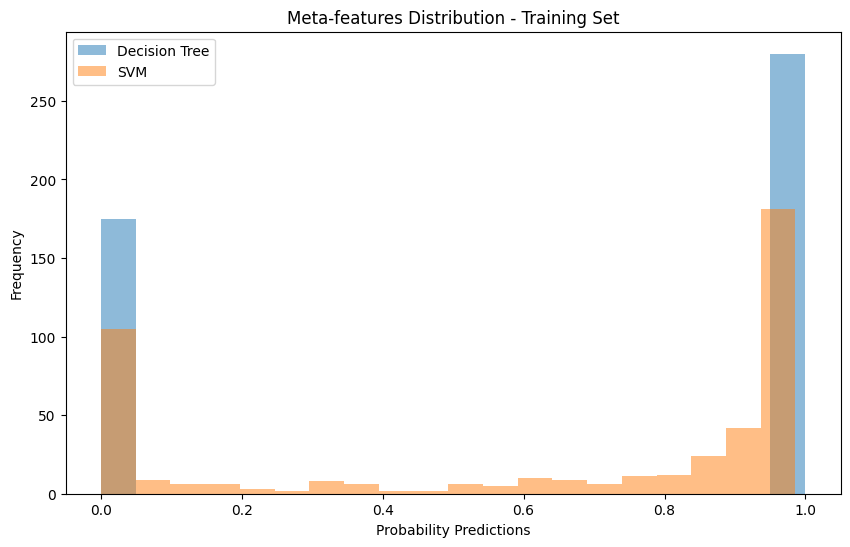

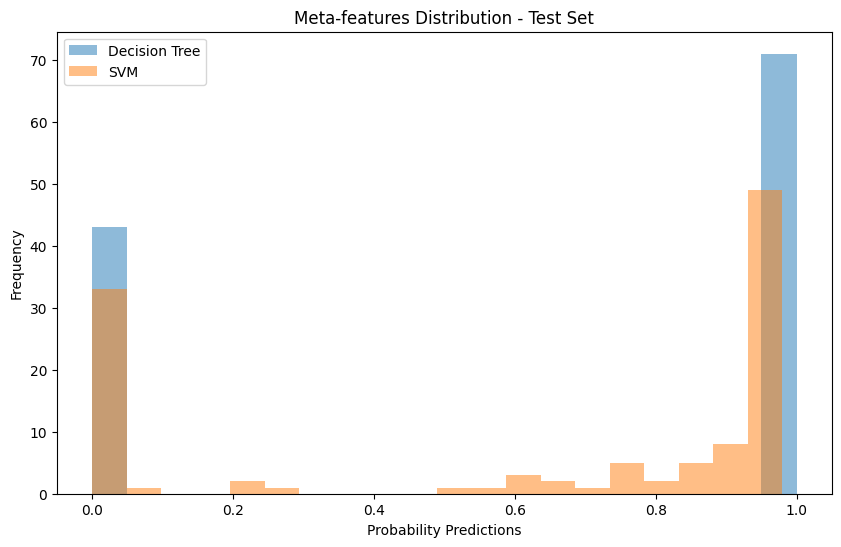

<ipython-input-10-38abd1af776e>:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores for scores in cv_scores.values()], labels=cv_scores.keys())


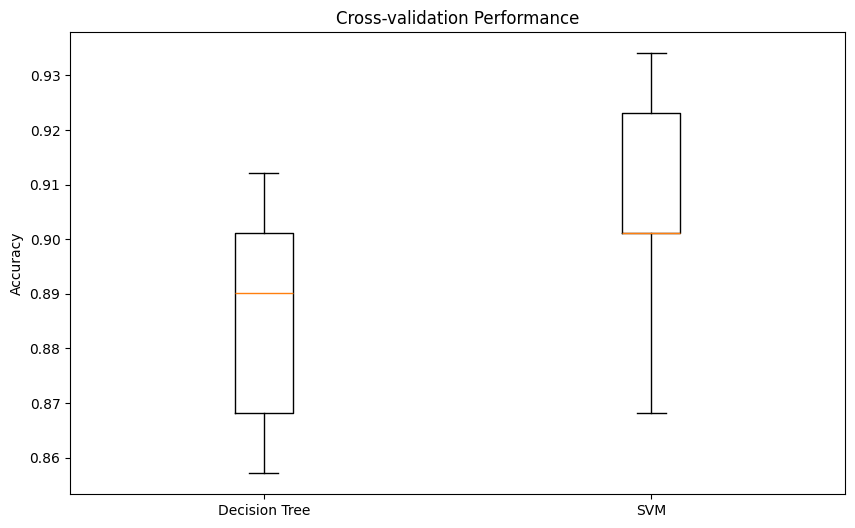

In [ ]:
# Initialize base models
base_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Initialize arrays for meta-features
X_train_meta = np.zeros((X_train.shape[0], len(base_models)))
X_test_meta = np.zeros((X_test.shape[0], len(base_models)))

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train base models with cross-validation
for i, (name, model) in enumerate(base_models.items()):
    print(f"\nTraining {name}...")

    # Cross-validation for training meta-features
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
        # Split data for this fold
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]

        # Train model on fold
        clone_model = clone(model)
        clone_model.fit(X_fold_train, y_fold_train)

        # Generate meta-features
        X_train_meta[val_idx, i] = clone_model.predict_proba(X_fold_val)[:, 1]

        print(f"Completed fold {fold}/5")

    # Train on full training set for test predictions
    model.fit(X_train, y_train)
    X_test_meta[:, i] = model.predict_proba(X_test)[:, 1]

# #added during screencast
# Visualize meta-features distribution
# =====================================

def plot_meta_features_distribution(X_meta, title):
    plt.figure(figsize=(10, 6))
    for i, name in enumerate(base_models.keys()):
        plt.hist(X_meta[:, i], bins=20, alpha=0.5, label=name)
    plt.title(f'Meta-features Distribution - {title}')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_meta_features_distribution(X_train_meta, 'Training Set')
plot_meta_features_distribution(X_test_meta, 'Test Set')

# #added during screencast
# Visualize cross-validation performance
# =====================================

def plot_cv_performance():
    cv_scores = {}

    for name, model in base_models.items():
        scores = []
        for train_idx, val_idx in kfold.split(X_train):
            clone_model = clone(model)
            clone_model.fit(X_train[train_idx], y_train[train_idx])
            score = clone_model.score(X_train[val_idx], y_train[val_idx])
            scores.append(score)
        cv_scores[name] = scores

    plt.figure(figsize=(10, 6))
    plt.boxplot([scores for scores in cv_scores.values()], labels=cv_scores.keys())
    plt.title('Cross-validation Performance')
    plt.ylabel('Accuracy')
    plt.show()

plot_cv_performance()

# Step 4: Train the Meta-Model
Now let's train and evaluate the meta-model.


Model Performance Comparison:
--------------------------
Decision Tree Accuracy: 0.947
SVM Accuracy: 0.947
Stacking Accuracy: 0.956


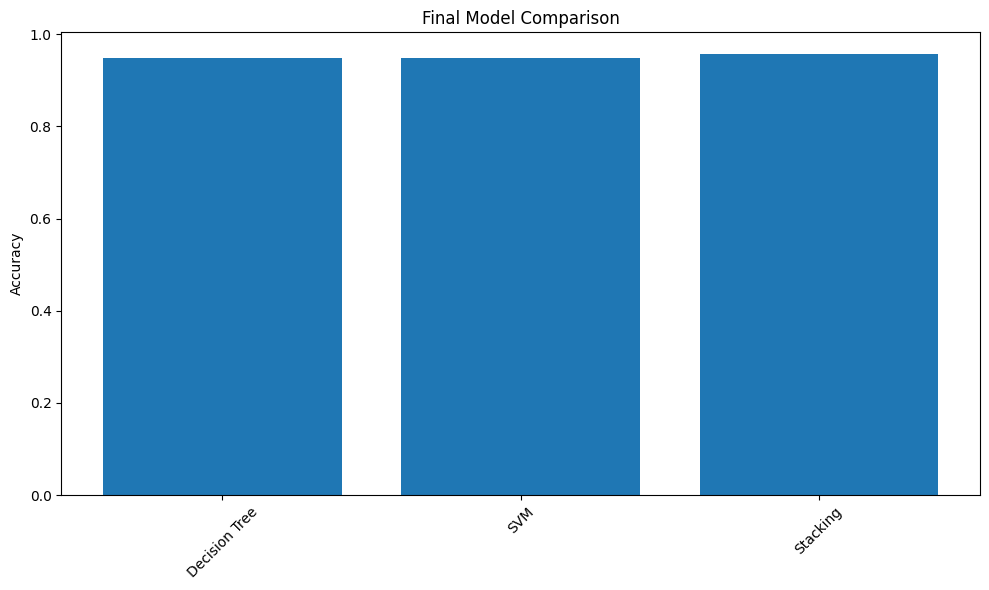

In [ ]:
# Train and evaluate meta-learner
# =====================================

# Train meta-learner
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(X_train_meta, y_train)

# Evaluate final stacking model
y_pred = meta_learner.predict(X_test_meta)
stacking_accuracy = accuracy_score(y_test, y_pred)

# Compare with base models
print("\nModel Performance Comparison:")
print("--------------------------")
for name, model in base_models.items():
    base_accuracy = model.score(X_test, y_test)
    print(f"{name} Accuracy: {base_accuracy:.3f}")
print(f"Stacking Accuracy: {stacking_accuracy:.3f}")

# Visualize final comparison
plt.figure(figsize=(10, 6))
accuracies = {**{name: model.score(X_test, y_test)
                 for name, model in base_models.items()},
              'Stacking': stacking_accuracy}
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Final Model Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()